# CS 6603: AI, Ethics, and Society
# Homework Project #3: AI/ML Part 1
### Import Necessary Libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Load the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('toxity_per_attribute.csv')

# Display the first few rows
df.head()


C:\Users\darie\AppData\Local\Temp\ipykernel_23000\3576028340.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('toxity_per_attribute.csv')


,Wiki_ID,TOXICITY,lesbian,gay,bisexual,transgender,trans,queer,lgbt,lgbtq,...,older,young,younger,teenage,millenial,middle aged,elderly,blind,deaf,paralyzed
0,0.0,0.096492,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,0.017991,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,0.150298,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3.0,0.065861,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4.0,0.667166,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Data Cleaning: Remove Empty Rows

In [4]:
# Remove any completely empty rows (if any)
df = df.dropna(how='all')


### Combine Redundant Subgroups

In [5]:
# Create a copy of the dataframe for updates
df_updated = df.copy()

# Combine redundant subgroups for Race/Ethnicity
df_updated['black_or_african_american'] = df_updated['black'] | df_updated['african american']
df_updated['hispanic_or_latino'] = df_updated['hispanic'] | df_updated['latino'] | df_updated['latina'] | df_updated['latinx']

# Combine redundant subgroups for Gender Identity
df_updated['transgender'] = df_updated['transgender'] | df_updated['trans']

# Combine redundant subgroups for Age
df_updated['older_adults'] = df_updated['old'] | df_updated['older'] | df_updated['elderly']
df_updated['young'] = df_updated['young'] | df_updated['younger']

# Combine 'catholic' and 'protestant' into 'christian' for Religion
df_updated['christian'] = df_updated['christian'] | df_updated['catholic'] | df_updated['protestant']

# Correct the spelling of 'millenial' to 'millennial'
df_updated.rename(columns={'millenial': 'millennial'}, inplace=True)


### Prepare the List of Subgroup Columns

In [6]:
# List of subgroup columns
subgroup_cols = df_updated.columns.tolist()
subgroup_cols.remove('Wiki_ID')
subgroup_cols.remove('TOXICITY')

# Remove redundant columns from subgroup_cols
redundant_columns = [
    'black', 'african american',
    'latino', 'latina', 'latinx', 'hispanic',
    'trans',
    'old', 'older', 'elderly',
    'young', 'younger',
    'catholic', 'protestant',
    'millenial'  # Already renamed
]

for col in redundant_columns:
    if col in subgroup_cols:
        subgroup_cols.remove(col)


### Define Protected Classes and Their Subgroups

In [7]:
# Define updated protected classes and their subgroups
protected_classes = {
    'Sexual Orientation': ['lesbian', 'gay', 'bisexual', 'queer', 'heterosexual'],
    'Gender Identity': ['transgender', 'male', 'female', 'nonbinary'],
    'Race/Ethnicity': ['black_or_african_american', 'white', 'asian', 'indian', 'chinese', 'japanese', 'middle eastern', 'hispanic_or_latino'],
    'National Origin': ['mexican', 'canadian', 'american', 'european'],
    'Religion': ['christian', 'muslim', 'jewish', 'buddhist', 'sikh', 'taoist'],
    'Age': ['young', 'teenage', 'millennial', 'middle aged', 'older_adults'],
    'Disability': ['blind', 'deaf', 'paralyzed']
}


### Create the Reduced Dataset

In [8]:
# Create a boolean mask where at least one subgroup is True
mask = df_updated[subgroup_cols].any(axis=1)

# Apply the mask to create the reduced dataset
df_reduced = df_updated[mask].reset_index(drop=True)

# Display the size of the reduced dataset
print(f"Reduced dataset contains {df_reduced.shape[0]} rows.")


Reduced dataset contains 72672 rows.


### Assign Numerical Values to Subgroups

In [9]:
# Initialize a copy of the reduced DataFrame
df_numerical = df_reduced.copy()

# Assign numerical values to subgroups within each protected class
for pc, subgroups in protected_classes.items():
    # Initialize the protected class column with zeros
    df_numerical[pc] = 0
    for idx, subgroup in enumerate(subgroups):
        # Assign a unique value to each subgroup (start from 1)
        subgroup_value = idx + 1
        # Ensure the subgroup exists in the DataFrame
        if subgroup in df_numerical.columns:
            # Update the protected class column where the subgroup is True
            df_numerical.loc[df_numerical[subgroup] == True, pc] = subgroup_value
        else:
            print(f"Warning: Subgroup '{subgroup}' not found in DataFrame columns.")


### Calculate Correlations with TOXICITY

In [26]:
# Calculate correlations with TOXICITY
correlation_results = []

for pc in protected_classes.keys():
    # Ensure there is variance in the protected class column
    if df_numerical[pc].nunique() > 1:
        corr_coef = df_numerical[pc].corr(df_numerical['TOXICITY'])
        strength = ''
        abs_corr = abs(corr_coef)
        if abs_corr >= 0.8:
            strength = 'Very Strong'
        elif abs_corr >= 0.6:
            strength = 'Strong'
        elif abs_corr >= 0.4:
            strength = 'Moderate'
        elif abs_corr >= 0.2:
            strength = 'Weak'
        else:
            strength = 'Very Weak'
        correlation_results.append({'Protected Class': pc, 'Correlation Coefficient': corr_coef, 'Strength': strength})
    else:
        # If there is no variance, correlation is not defined
        correlation_results.append({'Protected Class': pc, 'Correlation Coefficient': None, 'Strength': 'No Variance'})

# Create a DataFrame to display the results
correlation_df = pd.DataFrame(correlation_results)
correlation_df


,Protected Class,Correlation Coefficient,Strength
0,Sexual Orientation,0.144733,Very Weak
1,Gender Identity,0.028056,Very Weak
2,Race/Ethnicity,-0.063315,Very Weak
3,National Origin,-0.120602,Very Weak
4,Religion,0.015664,Very Weak
5,Age,-0.040035,Very Weak
6,Disability,0.010879,Very Weak


### Plot Subgroup Values vs. Toxicity

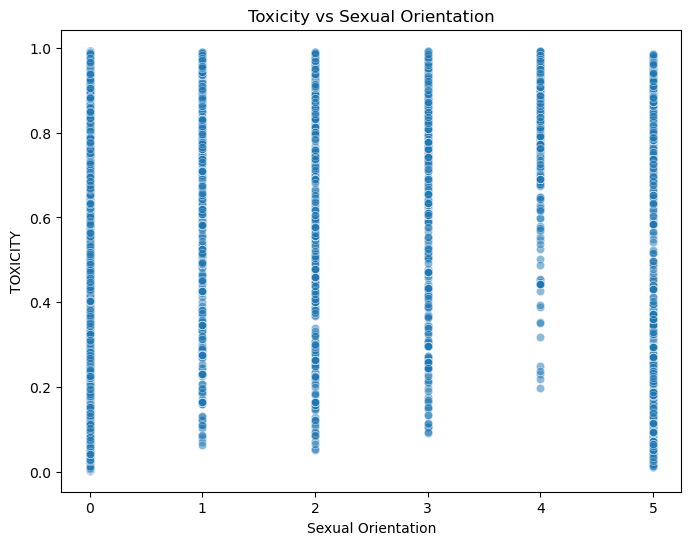

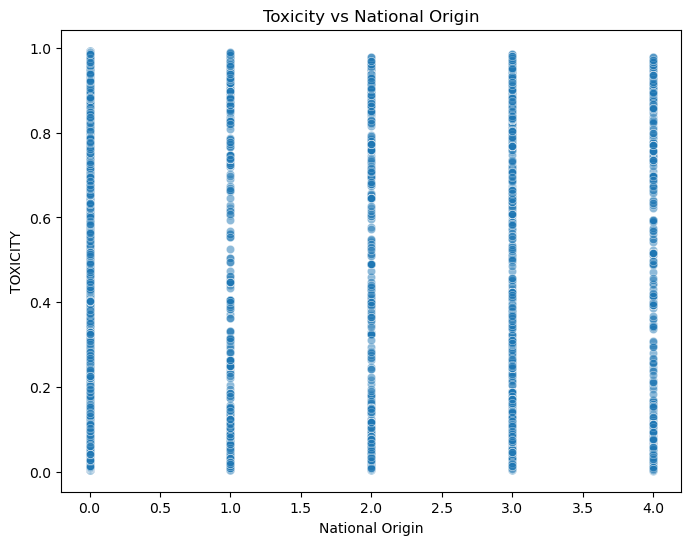

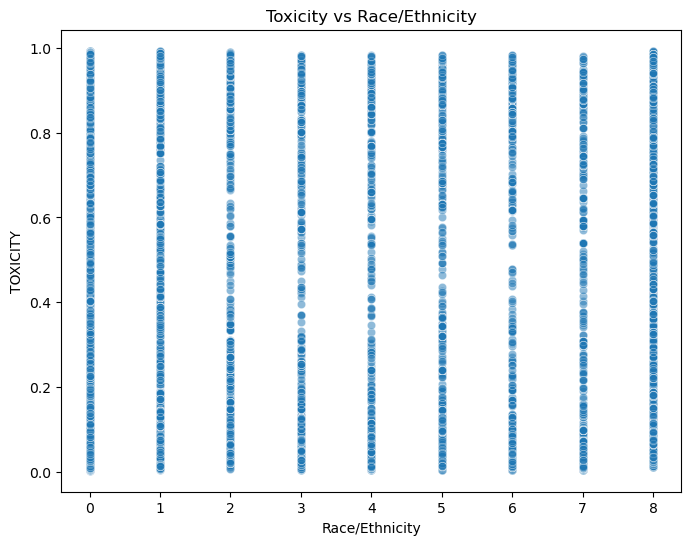

In [11]:
# Filter out protected classes where correlation could not be calculated
valid_correlations = correlation_df[correlation_df['Correlation Coefficient'].notnull()]

# Get the top three protected classes by absolute correlation
top_three_pcs = valid_correlations.reindex(valid_correlations['Correlation Coefficient'].abs().sort_values(ascending=False).index[:3])

# Plot Subgroup Values vs. Toxicity for the top three protected classes
for pc in top_three_pcs['Protected Class']:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_numerical[pc], y=df_numerical['TOXICITY'], alpha=0.5)
    plt.title(f'Toxicity vs {pc}')
    plt.xlabel(pc)
    plt.ylabel('TOXICITY')
    plt.show()


### Calculate Population Mean and Standard Deviation of TOXICITY

In [12]:
# Step 4.1: Calculate population mean and standard deviation of TOXICITY
population_mean = df_reduced['TOXICITY'].mean()
population_std = df_reduced['TOXICITY'].std()

print(f"Population Mean of TOXICITY: {population_mean}")
print(f"Population Standard Deviation of TOXICITY: {population_std}")

# Calculate the range that includes 95% of TOXICITY values
lower_bound = population_mean - 2 * population_std
upper_bound = population_mean + 2 * population_std

print(f"Range including 95% of TOXICITY values: [{lower_bound}, {upper_bound}]")


Population Mean of TOXICITY: 0.5522803057156813
Population Standard Deviation of TOXICITY: 0.36108433664414696
Range including 95% of TOXICITY values: [-0.1698883675726126, 1.2744489790039752]


### Random Sampling (10% and 60%)

In [13]:
# Step 4.2: Random sampling (10% of data)
sample_10_numerical = df_numerical.sample(frac=0.1, random_state=42)
sample_10_mean = sample_10_numerical['TOXICITY'].mean()
sample_10_std = sample_10_numerical['TOXICITY'].std()
n_10 = len(sample_10_numerical)
z_score = 1.96  # For 95% confidence
margin_of_error_10 = z_score * (sample_10_std / np.sqrt(n_10))

print(f"10% Sample Mean: {sample_10_mean}")
print(f"10% Sample Standard Deviation: {sample_10_std}")
print(f"10% Margin of Error: {margin_of_error_10}")

# Step 4.3: Random sampling (60% of data)
sample_60_numerical = df_numerical.sample(frac=0.6, random_state=42)
sample_60_mean = sample_60_numerical['TOXICITY'].mean()
sample_60_std = sample_60_numerical['TOXICITY'].std()
n_60 = len(sample_60_numerical)
margin_of_error_60 = z_score * (sample_60_std / np.sqrt(n_60))

print(f"60% Sample Mean: {sample_60_mean}")
print(f"60% Sample Standard Deviation: {sample_60_std}")
print(f"60% Margin of Error: {margin_of_error_60}")


10% Sample Mean: 0.5585281562593918
10% Sample Standard Deviation: 0.3630792668457379
10% Margin of Error: 0.008347951958331937
60% Sample Mean: 0.5540036827298581
60% Sample Standard Deviation: 0.36142942364615344
60% Margin of Error: 0.0033925119889076827


### Analyze TOXICITY for the Chosen Protected Class ('Gender Identity')

In [14]:
# Step 5.1: Analyze TOXICITY for the chosen protected class 'Gender Identity'
gender_identity_data = df_numerical[df_numerical['Gender Identity'] != 0]
gender_identity_mean = gender_identity_data['TOXICITY'].mean()
gender_identity_std = gender_identity_data['TOXICITY'].std()

print(f"Gender Identity Mean TOXICITY: {gender_identity_mean}")
print(f"Gender Identity Standard Deviation: {gender_identity_std}")


Gender Identity Mean TOXICITY: 0.5984416701509908
Gender Identity Standard Deviation: 0.3426628256090359


### Statistics for 'Gender Identity' in 10% and 60% Samples

In [15]:
# Step 5.2: Statistics for 'Gender Identity' in 10% sample
gender_sample_10 = sample_10_numerical[sample_10_numerical['Gender Identity'] != 0]
gender_sample_10_mean = gender_sample_10['TOXICITY'].mean()
gender_sample_10_std = gender_sample_10['TOXICITY'].std()
n_gender_10 = len(gender_sample_10)
margin_of_error_gender_10 = z_score * (gender_sample_10_std / np.sqrt(n_gender_10))

print(f"Gender Identity 10% Sample Mean: {gender_sample_10_mean}")
print(f"Gender Identity 10% Sample Standard Deviation: {gender_sample_10_std}")
print(f"Gender Identity 10% Margin of Error: {margin_of_error_gender_10}")

# Step 5.3: Statistics for 'Gender Identity' in 60% sample
gender_sample_60 = sample_60_numerical[sample_60_numerical['Gender Identity'] != 0]
gender_sample_60_mean = gender_sample_60['TOXICITY'].mean()
gender_sample_60_std = gender_sample_60['TOXICITY'].std()
n_gender_60 = len(gender_sample_60)
margin_of_error_gender_60 = z_score * (gender_sample_60_std / np.sqrt(n_gender_60))

print(f"Gender Identity 60% Sample Mean: {gender_sample_60_mean}")
print(f"Gender Identity 60% Sample Standard Deviation: {gender_sample_60_std}")
print(f"Gender Identity 60% Margin of Error: {margin_of_error_gender_60}")


Gender Identity 10% Sample Mean: 0.5920378684641944
Gender Identity 10% Sample Standard Deviation: 0.3498109305282784
Gender Identity 10% Margin of Error: 0.024518058140338417
Gender Identity 60% Sample Mean: 0.5967617638357079
Gender Identity 60% Sample Standard Deviation: 0.34399449583929326
Gender Identity 60% Margin of Error: 0.010059761655467549


### Check if Sample Means Lie Within Population Margin of Error

In [16]:
# Step 5.4: Check if sample means lie within population margin of error
within_margin_10 = (gender_sample_10_mean >= (sample_10_mean - margin_of_error_10)) and (gender_sample_10_mean <= (sample_10_mean + margin_of_error_10))
print(f"Does the Gender Identity 10% Sample Mean lie within the 10% Population Margin of Error? {'Yes' if within_margin_10 else 'No'}")

within_margin_60 = (gender_sample_60_mean >= (sample_60_mean - margin_of_error_60)) and (gender_sample_60_mean <= (sample_60_mean + margin_of_error_60))
print(f"Does the Gender Identity 60% Sample Mean lie within the 60% Population Margin of Error? {'Yes' if within_margin_60 else 'No'}")


Does the Gender Identity 10% Sample Mean lie within the 10% Population Margin of Error? No
Does the Gender Identity 60% Sample Mean lie within the 60% Population Margin of Error? No


### Analyze TOXICITY for Subgroups of 'Gender Identity'

In [17]:
# Step 6.1: Analyze TOXICITY for subgroups of 'Gender Identity'
subgroup_stats = []

for subgroup in protected_classes['Gender Identity']:
    if subgroup in df_numerical.columns:
        subgroup_data = df_numerical[df_numerical[subgroup] == True]
        mean = subgroup_data['TOXICITY'].mean()
        std = subgroup_data['TOXICITY'].std()
        subgroup_stats.append({'Subgroup': subgroup, 'Mean': mean, 'Standard Deviation': std})
    else:
        print(f"Warning: Subgroup '{subgroup}' not found in DataFrame columns.")

# Create a DataFrame for subgroup statistics
subgroup_df = pd.DataFrame(subgroup_stats)
subgroup_df


,Subgroup,Mean,Standard Deviation
0,transgender,0.624265,0.344623
1,male,0.585090,0.337777
2,female,0.603425,0.337007
3,nonbinary,0.555164,0.344547


### Statistics for Subgroups in 10% and 60% Samples

In [43]:
# Step 6.2: Statistics for subgroups in 10% sample
subgroup_stats_10 = []

for subgroup in protected_classes['Gender Identity']:
    if subgroup in sample_10_numerical.columns:
        subgroup_data_10 = sample_10_numerical[sample_10_numerical[subgroup] == True]
        mean = subgroup_data_10['TOXICITY'].mean()
        std = subgroup_data_10['TOXICITY'].std()
        n = len(subgroup_data_10)
        moe = z_score * (std / np.sqrt(n)) if n > 0 else None
        subgroup_stats_10.append({'Subgroup': subgroup, 'Mean': mean, 'Standard Deviation': std, 'Margin of Error': moe})
    else:
        print(f"Warning: Subgroup '{subgroup}' not found in DataFrame columns.")

subgroup_10_df = pd.DataFrame(subgroup_stats_10)
subgroup_10_df




,Subgroup,Mean,Standard Deviation,Margin of Error
0,transgender,0.632840,0.362207,0.039440
1,male,0.560396,0.345233,0.059809
2,female,0.593402,0.327836,0.049872
3,nonbinary,0.534744,0.342466,0.052415


In [44]:
# Step 6.3: Statistics for subgroups in 60% sample
subgroup_stats_60 = []

for subgroup in protected_classes['Gender Identity']:
    if subgroup in sample_60_numerical.columns:
        subgroup_data_60 = sample_60_numerical[sample_60_numerical[subgroup] == True]
        mean = subgroup_data_60['TOXICITY'].mean()
        std = subgroup_data_60['TOXICITY'].std()
        n = len(subgroup_data_60)
        moe = z_score * (std / np.sqrt(n)) if n > 0 else None
        subgroup_stats_60.append({'Subgroup': subgroup, 'Mean': mean, 'Standard Deviation': std, 'Margin of Error': moe})
    else:
        print(f"Warning: Subgroup '{subgroup}' not found in DataFrame columns.")

subgroup_60_df = pd.DataFrame(subgroup_stats_60)
subgroup_60_df

,Subgroup,Mean,Standard Deviation,Margin of Error
0,transgender,0.629510,0.345446,0.015819
1,male,0.582728,0.339237,0.022225
2,female,0.597509,0.334938,0.021981
3,nonbinary,0.541663,0.347503,0.023052


### Check if Subgroup Means Lie Within Population Margin of Error

In [19]:
# Step 6.4: Check if subgroup means lie within population margin of error for 10% sample
for idx, row in subgroup_10_df.iterrows():
    mean = row['Mean']
    if mean is not None and not pd.isna(mean):
        within_margin = (mean >= (sample_10_mean - margin_of_error_10)) and (mean <= (sample_10_mean + margin_of_error_10))
        subgroup_10_df.loc[idx, 'Within Population Margin'] = 'Yes' if within_margin else 'No'
    else:
        subgroup_10_df.loc[idx, 'Within Population Margin'] = 'N/A'

subgroup_10_df


,Subgroup,Mean,Standard Deviation,Margin of Error,Within Population Margin
0,transgender,0.632840,0.362207,0.039440,No
1,male,0.560396,0.345233,0.059809,Yes
2,female,0.593402,0.327836,0.049872,No
3,nonbinary,0.534744,0.342466,0.052415,No


In [20]:
# Step 6.4: Check if subgroup means lie within population margin of error for 60% sample
for idx, row in subgroup_60_df.iterrows():
    mean = row['Mean']
    if mean is not None and not pd.isna(mean):
        within_margin = (mean >= (sample_60_mean - margin_of_error_60)) and (mean <= (sample_60_mean + margin_of_error_60))
        subgroup_60_df.loc[idx, 'Within Population Margin'] = 'Yes' if within_margin else 'No'
    else:
        subgroup_60_df.loc[idx, 'Within Population Margin'] = 'N/A'

subgroup_60_df


,Subgroup,Mean,Standard Deviation,Margin of Error,Within Population Margin
0,transgender,0.629510,0.345446,0.015819,No
1,male,0.582728,0.339237,0.022225,No
2,female,0.597509,0.334938,0.021981,No
3,nonbinary,0.541663,0.347503,0.023052,No


### Plot the Computed Means and Standard Deviations

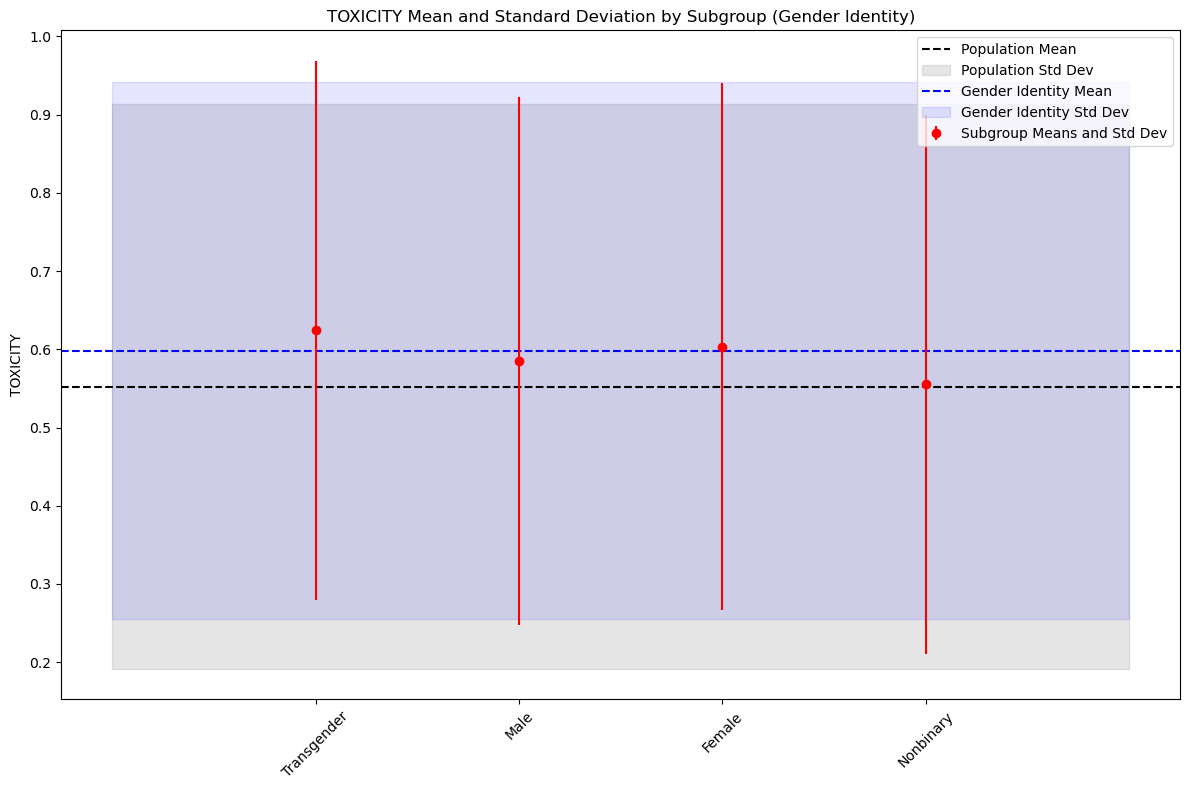

In [21]:
# Step 7: Plot the computed means and standard deviations
# Prepare data for plotting
plot_data = subgroup_df.copy()
plot_data['Subgroup'] = plot_data['Subgroup'].str.title()

# Plotting
plt.figure(figsize=(12, 8))

# Population mean and std
plt.axhline(y=population_mean, color='black', linestyle='--', label='Population Mean')
plt.fill_between(x=[-1, len(plot_data)], y1=population_mean - population_std, y2=population_mean + population_std, color='grey', alpha=0.2, label='Population Std Dev')

# Protected class mean and std
plt.axhline(y=gender_identity_mean, color='blue', linestyle='--', label='Gender Identity Mean')
plt.fill_between(x=[-1, len(plot_data)], y1=gender_identity_mean - gender_identity_std, y2=gender_identity_mean + gender_identity_std, color='blue', alpha=0.1, label='Gender Identity Std Dev')

# Subgroup means and stds
plt.errorbar(x=range(len(plot_data)), y=plot_data['Mean'], yerr=plot_data['Standard Deviation'], fmt='o', color='red', label='Subgroup Means and Std Dev')

# Customize the plot
plt.xticks(range(len(plot_data)), plot_data['Subgroup'], rotation=45)
plt.ylabel('TOXICITY')
plt.title('TOXICITY Mean and Standard Deviation by Subgroup (Gender Identity)')
plt.legend()
plt.tight_layout()
plt.show()


### Question 1: Which Subgroup Has the Highest TOXICITY Value?

In [22]:
highest_toxicity_subgroup = subgroup_df.loc[subgroup_df['Mean'].idxmax()]
print(f"The subgroup with the highest TOXICITY is {highest_toxicity_subgroup['Subgroup']} with a mean TOXICITY of {highest_toxicity_subgroup['Mean']:.4f}.")


The subgroup with the highest TOXICITY is transgender with a mean TOXICITY of 0.6243.


### Question 2: Which Subgroup Has the Lowest TOXICITY Value?

In [23]:
lowest_toxicity_subgroup = subgroup_df.loc[subgroup_df['Mean'].idxmin()]
print(f"The subgroup with the lowest TOXICITY is {lowest_toxicity_subgroup['Subgroup']} with a mean TOXICITY of {lowest_toxicity_subgroup['Mean']:.4f}.")


The subgroup with the lowest TOXICITY is nonbinary with a mean TOXICITY of 0.5552.


### Question 3: Which Subgroup Has the Largest Difference in TOXICITY Value Compared to the Population Mean?

In [24]:
# Calculate the absolute difference from the population mean
subgroup_df['Difference from Population Mean'] = abs(subgroup_df['Mean'] - population_mean)

# Identify the subgroup with the largest difference
largest_diff_subgroup = subgroup_df.loc[subgroup_df['Difference from Population Mean'].idxmax()]
print(f"The subgroup with the largest difference from the population mean is {largest_diff_subgroup['Subgroup']} with a difference of {largest_diff_subgroup['Difference from Population Mean']:.4f}.")


The subgroup with the largest difference from the population mean is transgender with a difference of 0.0720.
